# 📘 Masar Station-Level 30-Minute Demand Forecasting Notebook

This notebook builds a complete machine-learning pipeline for forecasting station-level passenger demand 30 minutes ahead. It processes raw Masar data, engineers time-based and operational features, encodes categorical attributes, and trains a Random Forest model to learn short-term passenger flow dynamics.

By leveraging historical patterns, lag variables, event indicators, and service features, the model produces reliable short-term forecasts that support simulation workflows, operational planning, and real-time decision systems.

# 🎯 Purpose

The objective of this notebook is to construct a predictive model that estimates future passenger counts based on:

* Time-of-day and weekday behavior
* Operational variables (headway, modifiers, flows)
* Recency-based lag features
* Event and holiday disruptions
* Station identity and historical movement patterns

The output serves as a foundational forecasting component for downstream simulation engines, demand-adjustment modules, and deployment pipelines.

In [1]:
!git clone https://github.com/Jana-Alrzoog/2025_GP_28.git
%cd 2025_GP_28


Cloning into '2025_GP_28'...
remote: Enumerating objects: 897, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 897 (delta 53), reused 31 (delta 15), pack-reused 760 (from 4)
Receiving objects: 100% (897/897), 42.06 MiB | 22.12 MiB/s, done.
Resolving deltas: 100% (333/333), done.
/content/2025_GP_28


# Load & Prepare September Dataset

In [2]:
# ============================================================
# 1. Load and Prepare Dataset
# ============================================================

import pandas as pd

df = pd.read_csv(
    "masar-sim/data/generated/2025-09_StationData.csv",
    parse_dates=["timestamp"]
)

df = df.sort_values(["station_id", "timestamp"]).reset_index(drop=True)
df.head()


/tmp/ipython-input-3681429631.py:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,date,timestamp,hour,minute_of_day,day_of_week,is_weekend,station_id,headway_seconds,base_demand,modifier,...,holiday_flag,lag_5,lag_15,lag_30,lag_60,lag_120,roll_mean_15,roll_std_15,roll_mean_60,target_30min
0,2025-09-01,2025-09-01 00:00:00,0,0,0,0,S1,660,0.110000,1.0,...,0,NaN,NaN,NaN,NaN,NaN,154.0,NaN,154.0,NaN
1,2025-09-01,2025-09-01 06:00:00,6,360,0,0,S1,660,0.210551,1.0,...,0,NaN,NaN,NaN,NaN,NaN,295.0,NaN,295.0,NaN
2,2025-09-01,2025-09-01 06:01:00,6,361,0,0,S1,660,0.216663,1.0,...,0,NaN,NaN,NaN,NaN,NaN,299.5,6.363961,299.5,NaN
3,2025-09-01,2025-09-01 06:02:00,6,362,0,0,S1,660,0.223091,1.0,...,0,NaN,NaN,NaN,NaN,NaN,304.0,9.000000,304.0,NaN
4,2025-09-01,2025-09-01 06:03:00,6,363,0,0,S1,660,0.229847,1.0,...,0,NaN,NaN,NaN,NaN,NaN,308.5,11.618950,308.5,NaN


# Preprocess Lag and Rolling Window Features

In [3]:
# ============================================================
# 2. Clean Lag and Rolling-Window Features
# ============================================================

lag_roll_cols = [
    "lag_5", "lag_15", "lag_30", "lag_60", "lag_120",
    "roll_mean_15", "roll_std_15", "roll_mean_60"
]

df[lag_roll_cols] = df[lag_roll_cols].fillna(0)


In [4]:
# ============================================================
# 3. Construct 30-Minute Future Target
# ============================================================

df["target_30m"] = df.groupby("station_id")["station_total"].shift(-30)
df = df.dropna(subset=["target_30m"]).reset_index(drop=True)
df["target_30m"] = df["target_30m"].astype(float)


In [5]:
# ============================================================
# 4. Engineer Temporal Features
# ============================================================

df["hour"] = df["timestamp"].dt.hour
df["minute_of_day"] = df["timestamp"].dt.hour * 60 + df["timestamp"].dt.minute
df["day_of_week"] = df["timestamp"].dt.weekday
df["is_weekend"] = df["day_of_week"].isin([4, 5]).astype(int)


# Encoding Station Identifiers (S1–S6)

In [6]:
# ============================================================
# 5️. Encode Station Identifiers
# ============================================================

fixed_station_order = ["S1", "S2", "S3", "S4", "S5", "S6"]

station_mapping = {name: idx+1 for idx, name in enumerate(fixed_station_order)}

df["station_id_mapped"] = df["station_id"].map(station_mapping)

# Preprocess & Encode Special Event Types

In [7]:
# ============================================================
# 6️. Encode Special Event Categories
# ============================================================

df["special_event_type"] = df["special_event_type"].fillna("None")

fixed_event_order = [
    "None",
    "Festival",
    "Sports",
    "NationalHoliday",
    "Holiday",
    "Conference",
    "Exhibition",
    "Concert",
    "Expo",
    "AirportSurge"
]
event_mapping = {name: idx for idx, name in enumerate(fixed_event_order)}

df["special_event_type"] = df["special_event_type"].fillna("None")
df["special_event_type_mapped"] = df["special_event_type"].map(event_mapping)

In [8]:
# ============================================================
# 7️. Build Feature Matrix (X) and Target Vector (y)
# ============================================================

feature_cols = [
    "hour", "minute_of_day", "day_of_week", "is_weekend",
    "station_id_mapped", "headway_seconds", "station_flow_per_min", "special_event_type_mapped",
    "event_flag", "holiday_flag", "station_total",
    "lag_5", "lag_15", "lag_30", "lag_60", "lag_120",
    "roll_mean_15", "roll_std_15", "roll_mean_60",
]


In [9]:
X = df[feature_cols].copy()
y = df["target_30m"].copy()


# Create Time-Based Train/Val/Test Split

In [24]:
# ============================================================
# 8. Chronological Train-Test Split
# ============================================================

total_len = len(df)

train_end = int(total_len * 0.70)
val_end   = int(total_len * 0.85)


X_train = X.iloc[:train_end]
X_val   = X.iloc[train_end:val_end]
X_test  = X.iloc[val_end:]


y_train = y.iloc[:train_end]
y_val   = y.iloc[train_end:val_end]
y_test  = y.iloc[val_end:]

print(len(X_train), len(X_val), len(X_test))


136080 29160 29160


# Define and Fit the Random Forest Regression Model

In [25]:
# ============================================================
# 9️. Train Random Forest Regressor
# ============================================================

from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, min_samples_leaf=3, n_estimators=300,
                      n_jobs=-1, random_state=42)

# Model Evaluation: RMSE, MAE, and R² Scores

In [26]:
# ============================================================
# 10. Evaluate Model Performance (Train / Val / Test)
# ============================================================

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from math import sqrt

# -------- TRAIN --------
y_pred_train = rf_model.predict(X_train)
train_mae  = mean_absolute_error(y_train, y_pred_train)
train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
train_r2   = r2_score(y_train, y_pred_train)

print("Train metrics:")
print("RMSE:", round(train_rmse, 2))
print("MAE :", round(train_mae, 2))
print("R^2 :", round(train_r2, 3))
print("\n")

# -------- VALIDATION --------
y_pred_val = rf_model.predict(X_val)
val_mae  = mean_absolute_error(y_val, y_pred_val)
val_rmse = sqrt(mean_squared_error(y_val, y_pred_val))
val_r2   = r2_score(y_val, y_pred_val)

print("Validation metrics:")
print("RMSE:", round(val_rmse, 2))
print("MAE :", round(val_mae, 2))
print("R^2 :", round(val_r2, 3))
print("\n")

# -------- TEST --------
y_pred_test = rf_model.predict(X_test)
test_mae  = mean_absolute_error(y_test, y_pred_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))
test_r2   = r2_score(y_test, y_pred_test)

print("Test metrics:")
print("RMSE:", round(test_rmse, 2))
print("MAE :", round(test_mae, 2))
print("R^2 :", round(test_r2, 3))


Train metrics:
RMSE: 24.62
MAE : 3.19
R^2 : 1.0


Validation metrics:
RMSE: 210.2
MAE : 52.57
R^2 : 0.969


Test metrics:
RMSE: 462.26
MAE : 280.41
R^2 : 0.177


# 📌 Model Performance Summary

The Random Forest model performs extremely well on the training data, but the validation and test results highlight important limitations related to temporal generalization.


**Train R² = 1.000**

Perfect fit on the training set, indicating the model memorizes earlier patterns extremely well.


**Validation R² = 0.969**

Strong performance but with higher errors, suggesting the validation window differs slightly from the training distribution.


**Test R² = 0.177**

A major drop in accuracy. The high MAE and RMSE show that the model struggles to generalize to future unseen data due to distribution shift.


# 🧠 Interpretation

The model captures historical patterns very well and maintains good performance on data that is temporally close to the training window.
However, the dramatic decline on the test set indicates that the model is sensitive to shifts in demand behavior and does not generalize well when the temporal distribution changes significantly.


# 🎯 Conclusion

The model is not stable across future time windows. Improving generalization will require feature adjustments, reduced complexity, or using more robust models such as XGBoost.

# Visualizing Predictions: Validation Set & Test Set

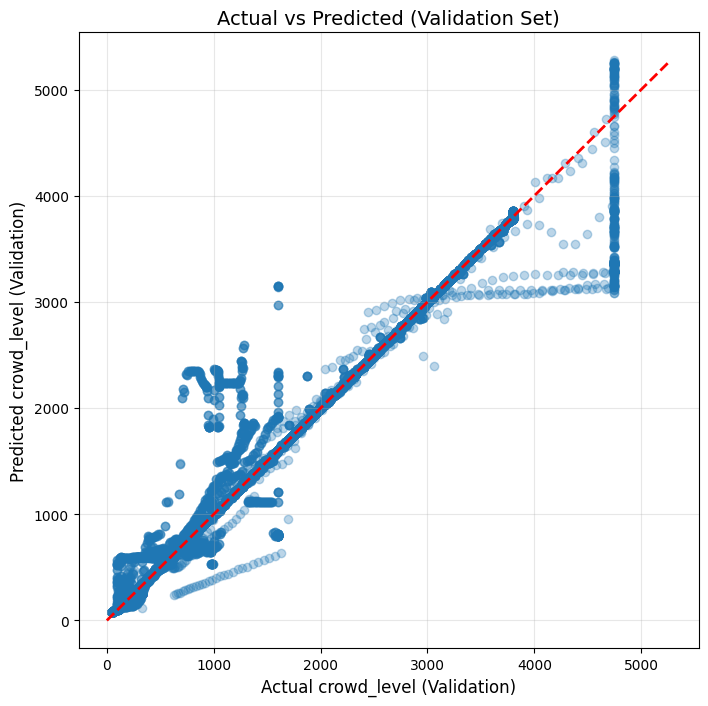

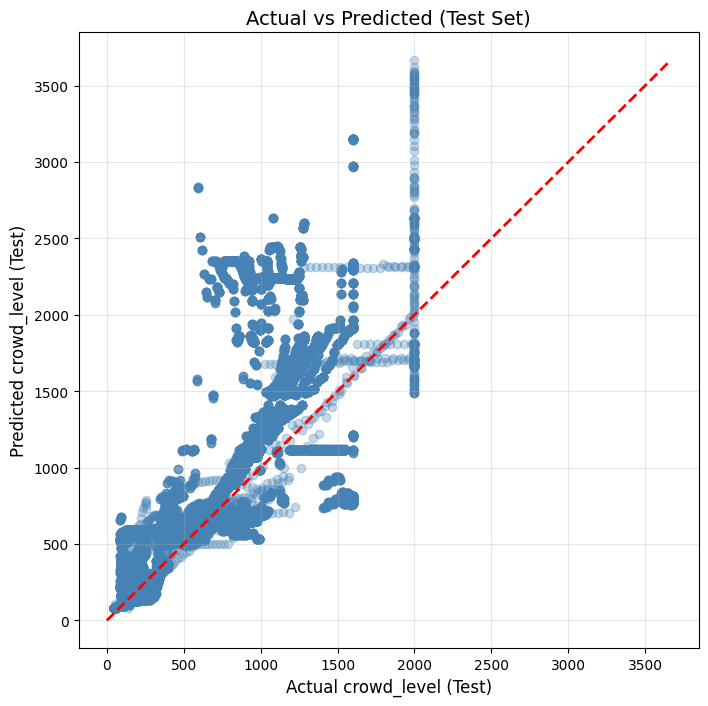

In [27]:
# ============================================================
# 📊 Plot: Actual vs Predicted (Validation Set)
# ============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred_val, alpha=0.3)

max_val = max(max(y_val), max(y_pred_val))
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)

plt.title("Actual vs Predicted (Validation Set)", fontsize=14)
plt.xlabel("Actual crowd_level (Validation)", fontsize=12)
plt.ylabel("Predicted crowd_level (Validation)", fontsize=12)

plt.grid(alpha=0.3)
plt.show()
# ============================================================
# 📊 Plot: Actual vs Predicted (Test Set)
# ============================================================

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.3, color='steelblue')

max_val = max(max(y_test), max(y_pred_test))
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)

plt.title("Actual vs Predicted (Test Set)", fontsize=14)
plt.xlabel("Actual crowd_level (Test)", fontsize=12)
plt.ylabel("Predicted crowd_level (Test)", fontsize=12)

plt.grid(alpha=0.3)
plt.show()


# 📌 Difference Between Validation and Test Performance

* The **validation scatter plot** shows predictions closely following the diagonal line, indicating that the model performs well on data that is similar to the training period.

* the **test scatter plot** is much more dispersed, with many points far from the ideal line, showing that the model struggles to generalize to future time segments.


This visual contrast confirms a strong distribution shift: the validation window remains close to the training pattern, while the test window contains new or different crowd behaviors that the model was not exposed to during training.

# 🎯 Summary

Validation accuracy appears reasonable because the data resembles the training period, while test performance drops sharply due to temporal changes and variability in the future window.

# Save Final XGBoost Model for Deployment

In [28]:
# ============================================================
# 11. Save Model and Encoding Dictionaries
# ============================================================

import joblib, json

joblib.dump(rf_model, "rf_station_total_30m.pkl")
json.dump(station_mapping, open("station_mapping.json", "w"))
json.dump(event_mapping, open("event_mapping.json", "w"))
